# Neural Processes

This implementation is based on [EmilienDupont/neural-processes]((https://github.com/EmilienDupont/neural-processes)).

## Overview of files

- **neuralprocess.py** contains *NeuralProcess()* model class and the following functions:
  - *__init__()* - Initialisies all three coders
    - *self.xy_to_r* - rEncoder
    - *self.r_to_mu_sigma* - zEncoder
    - *self.xz_to_y* - Decoder
  - *aggregate()* - Mean aggregation, permutation invariance
  - *xy_to_mu_sigm()* - Encoding via rEncoder and zEncoder
  - *forward()* - full forward pass
    - *training mode* - uses target encoding for z?!
    - *testing mode*  
  

- **coders.py** contains all three coders
  - *rEncoder()* - 2-layer (2 hidden layers) MLP with ReLu activation functions. Last layer without activation.
  - *zEncoder()* - 1-layer (1 hidden layer) MLP with ReLu activation function mapping r_agg to z parameters. Sigma is defined using 0.1 + 0.9 * sigmoid() (latent variance clipping to [0.1, 1]). 
  - *Decoder()* - 3-layer (3 hidden layers) MLP with ReLu activation functions. Sigma is defined using 0.1 + 0.9 * softplus() (thus unbounded).

- **utisl.py** contains helper functions:
  - *context_target_split()* - samples x_target, y_target and their subsets x_context and x_target.

- **datasets.py**
  - *SineData()*
  - *SineDisconData()*

-  **training.py** contains *NeuralProcessTrainer()* class and the following functions:
   - *loss()* Log-likelihood of y_predcitions and ELBO term (KL divergence of q_targets/q_context)
   - backpropagation possible due to reparametrisation trick.


## Implementation recommendations: 

- [Le, Tuan Anh, et al. "Empirical evaluation of neural process objectives." NeurIPS workshop on Bayesian Deep Learning. Vol. 4. 2018.](http://bayesiandeeplearning.org/2018/papers/92.pdf)
  - context size m and target size n (superset) with m < n.
  - activation on scale output of encoder and decoder.


## ToDos
- represenation aggregation over batches or full task?
- target and context modes during training and testing
- expressivity of variance under decoder implementation
  - visualise co-varaicne function
- increase batch size in examples
- understand comment about fixed observation variance (in Garnelo)
  - add observation noise
- visualise loss
- Vary number of contexts

- variance is still too large

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visualize Sine Data

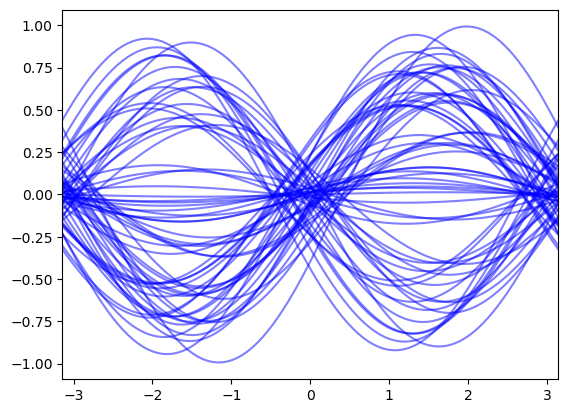

In [2]:
from datasets import SineData
from math import pi

# Create dataset
dataset = SineData(amplitude_range = (-1, 1), # amplitude_range = (1, 1)
                   shift_range = (-0.5, 0.5), # shift_range = (-.5, .5) shift_range = (0, 0)
                   num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'b', alpha = 0.5)
    plt.xlim(-pi, pi)

## Visualize SineDiscontionous Data

$$ \text{for } x < bp: \\
 f(x) = a * sin(x - b)
$$

$$ \text{for } x \geq bp: \\
 f(x) = a * sin(x - b) + c
$$

$$ \text{with } \\
a\text{: amplitude scalar sampled uniformly from }(0.5, 1.)\\
b\text{: horizontal shift sampled uniformly from }(-0.5, 0.5)\\
c\text{: vertical shift sampled uniformly from }(0, 1)\\
bp\text{: breakpoint fixed to }(0).
$$

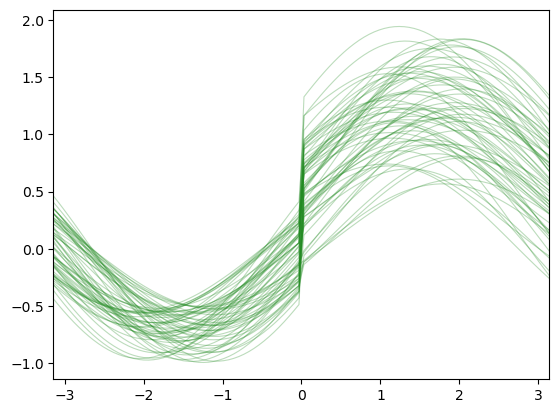

In [3]:
from math import pi
from datasets import SineDiscontData

dataset = SineDiscontData(num_samples = 2000)

# Visualize data samples
for i in range(64):
    x, y = dataset[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8' )
    plt.xlim(-pi, pi)

### Build Neural Process

In [8]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

<generator object Module.parameters at 0x7fa4284b6120>


### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

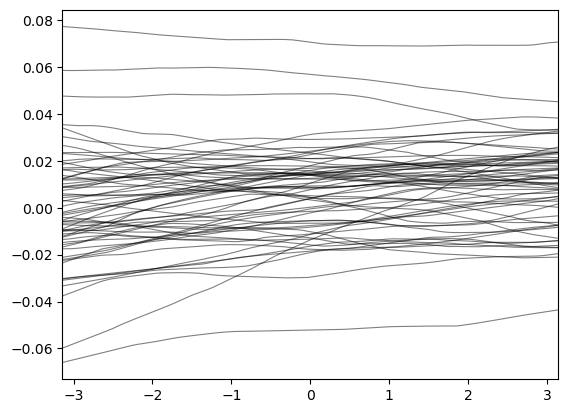

In [5]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'black', alpha = 0.5, linewidth = '.8')
    plt.xlim(-pi, pi)

### Train Neural Process

In [86]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 4 # increase
num_context = 4
num_target = 4 # extra targets

data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr = 3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range = (num_context, num_context),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 200)

# Training mode
neuralprocess.training = True
np_trainer.train(data_loader, epochs = 60)

iteration 200, loss -4.264
iteration 400, loss -6.358
Epoch: 0, Avg_loss: -4.701325040578842
iteration 600, loss -3.875
iteration 800, loss -5.391
iteration 1000, loss -7.106
Epoch: 1, Avg_loss: -4.906139010071755
iteration 1200, loss -4.045
iteration 1400, loss -4.680
Epoch: 2, Avg_loss: -4.836524742126465
iteration 1600, loss -4.678
iteration 1800, loss -3.192
iteration 2000, loss -6.323
Epoch: 3, Avg_loss: -5.015109599351883
iteration 2200, loss -5.996
iteration 2400, loss -2.982
Epoch: 4, Avg_loss: -4.932732417047024
iteration 2600, loss -5.417
iteration 2800, loss -8.265
iteration 3000, loss -7.270
Epoch: 5, Avg_loss: -4.888558976888657
iteration 3200, loss -4.299
iteration 3400, loss -5.231
Epoch: 6, Avg_loss: -4.990182364821434
iteration 3600, loss -6.768
iteration 3800, loss -5.412
iteration 4000, loss -5.911
Epoch: 7, Avg_loss: -4.905825655221939
iteration 4200, loss -4.701
iteration 4400, loss -5.434
Epoch: 8, Avg_loss: -4.999962974607945
iteration 4600, loss -7.500
iteration

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

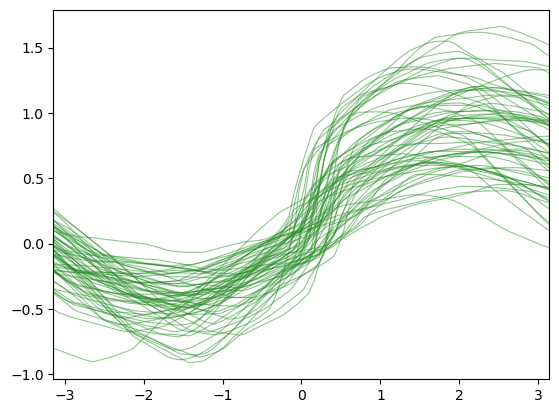

In [103]:
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c = 'forestgreen', alpha = 0.5, linewidth = "0.8")
    plt.xlim(-pi, pi)

### Visualize samples from posterior

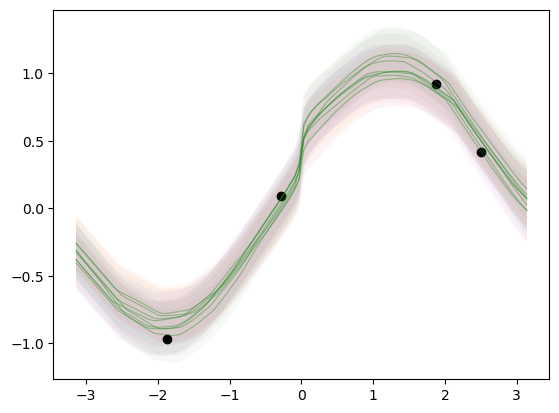

In [102]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

# showing 8
for i in range(8):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

- currently still underfitting a little bit to the context points

## Experiment 2

Change parameters

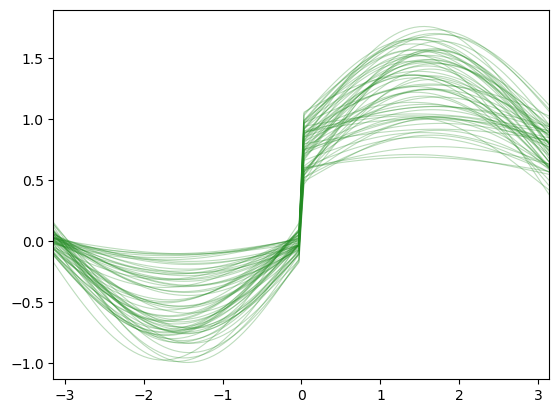

In [104]:
dataset2 = SineDiscontData(num_samples = 2000, amplitude_range = (0.1, 1.), 
                          horizontal_shift_range = (-.2, .2), 
                          vertical_shift_range = (0.5, 1))

# Visualize data samples
for i in range(64):
    x, y = dataset2[i] 
    plt.plot(x.numpy(), y.numpy(), c = 'forestgreen', alpha = 0.3, linewidth = '.8' )
    plt.xlim(-pi, pi)

In [105]:
from neuralprocess import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 128  # Dimension of representation of context points
z_dim = 128  # Dimension of sampled latent variable
h_dim = 64  # Dimension of hidden layers in encoder and decoder

neuralprocess2 = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

In [106]:
batch_size = 2
num_context = 4
num_target = 4 # extra targets

data_loader2 = DataLoader(dataset2, batch_size = batch_size, shuffle = True)
optimizer2 = torch.optim.Adam(neuralprocess2.parameters(), lr = 3e-4)
np_trainer2 = NeuralProcessTrainer(device, neuralprocess2, optimizer2,
                                  num_context_range = (num_context, num_context),
                                  num_extra_target_range = (num_target, num_target), 
                                  print_freq = 200)

# Trainind mode
neuralprocess2.training = True
np_trainer2.train(data_loader2, epochs = 90)
# Originally it was 30

iteration 200, loss 4.801
iteration 400, loss 6.331
iteration 600, loss 3.092
iteration 800, loss -0.621
iteration 1000, loss 2.119
Epoch: 0, Avg_loss: 3.627908095653169
iteration 1200, loss -1.114
iteration 1400, loss -1.530
iteration 1600, loss -1.450
iteration 1800, loss -0.128
iteration 2000, loss 5.294
Epoch: 1, Avg_loss: -1.0884550349283963
iteration 2200, loss -3.297
iteration 2400, loss -5.316
iteration 2600, loss -5.405
iteration 2800, loss -2.423
iteration 3000, loss -1.886
Epoch: 2, Avg_loss: -2.3886378529965877
iteration 3200, loss -3.403
iteration 3400, loss -4.436
iteration 3600, loss -2.915
iteration 3800, loss -5.118
iteration 4000, loss -4.364
Epoch: 3, Avg_loss: -3.2461845354065297
iteration 4200, loss 1.688
iteration 4400, loss -3.044
iteration 4600, loss -7.728
iteration 4800, loss -3.919
iteration 5000, loss -5.619
Epoch: 4, Avg_loss: -4.08004047457315
iteration 5200, loss -4.281
iteration 5400, loss -7.569
iteration 5600, loss -6.462
iteration 5800, loss -6.303
it

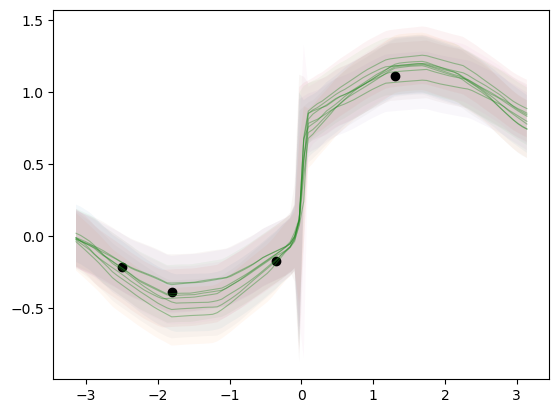

In [149]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader2:
    break

# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-pi, pi, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess2.training = False

# showing 8
for i in range(8):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess2(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    sigma = p_y_pred.scale.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha = 0.4, c = 'forestgreen', linewidth = '0.8')
    plt.fill_between(x = x_target.numpy()[0].squeeze(), 
                     y1 = (mu.numpy()[0] - 2 * sigma.numpy()[0]).squeeze(), 
                     y2 = (mu.numpy()[0] + 2 * sigma.numpy()[0]).squeeze(),
             alpha = 0.05,)

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')